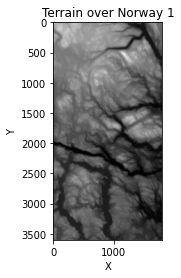

In [25]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
# Load the terrain
terrain = imread('data/SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')plt.show()


In [26]:
def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k[:, 1:])

	return X

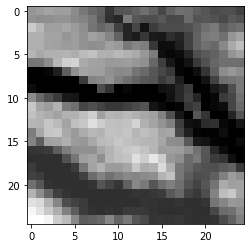

In [27]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_erro, r2_scorer
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

z = te2000n2500:20[150051000:20,
z -= np.min(z)
z = z / np.max(z)

plt.imshow(z, cmap='gray')
t data

x = np.li nspace(0,1, np.shape(z)[0])
y = np.l inspace(0,1, np.shape(z)[1])
x, y = np.meshgrid(x,y)

# __OLS__

In [28]:
from sklearn.linear_model import LinearRegression

RANDOM_STAT= 41042
max_degree16
degrees = np.arange(1, max_degree)= ols_6

_rain_MSE = np.zeros(max_d - 1egols_ree)
test_MSE = np.zeros(max_ - 1d
ols_r2 = np.zeros(max_degree - 1)eols_gree)
cv_score = np.zeros(max - 1_degree)

for idegrees)_degree)):
    X = create_X(x, y, i)

    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, tes
    model = m
    model = make_pipeline(StanLinearRegression()arRegression())
    model.fit(X_train, z_train)
    z_tilde = model.predict(X_train)
    z_pred = mode
.predols_train_MSEt) - 1

    train_MSE[i] = z_trainuaz_tildeor(z_tols_test_MSEtr - 1ain)
    test_MSE[i] =z_testsqz_prede
    ols_r2[i - 1] = r2_score(z_test, z_pred)ed_error', cv=KFold(10)))

100%|██████████| 15/15 [00:00<00:00, 42.75it/s]


In [29]:
for i in tqdm(degrees):
    X = create_X(x, y, i)
    model = make_pipeline(StandardScaler(), LinearRegression())
    ols_cv_score[i - 1] = -np.mean(cross_val_score(model, X, z.reshape(-1, 1), scoring='neg_mean_squared_error', cv=KFold(10, shuffle=True)))

100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


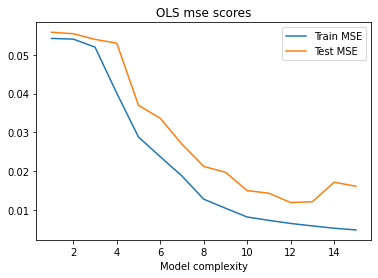

In [30]:
fig, ax = plt.subplots())
ax.plodegreese)ols_, train_MSE, label='Tra MSEin')
ax.pldegreeseeols_), test_MSE, label='T MSEeste')
ax.leg
ax.set_title('OLS mse scores')end()
ax.set_xlabel('Model comple('MSE')
plt.show()

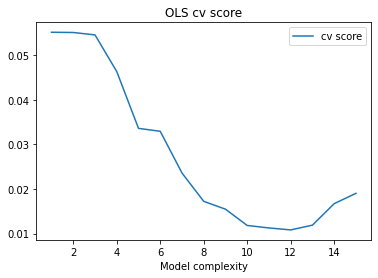

In [31]:
fig, ax = plt.subplots()
ax.plot(degrees, ols_cv_score, label='cv score')
ax.legend()
ax.set_title('OLS cv score')
ax.set_xlabel('Model complexity')
plt.show()

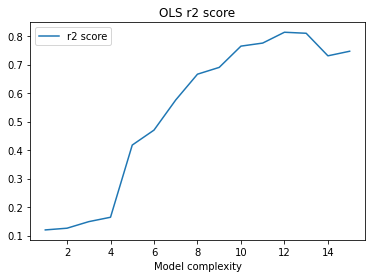

In [32]:
fig, ax = plt.subplots()
ax.plot(degrees, ols_r2, label='r2 score')
ax.legend()
ax.set_title('OLS r2 score')
ax.set_xlabel('Model complexity')
plt.show()

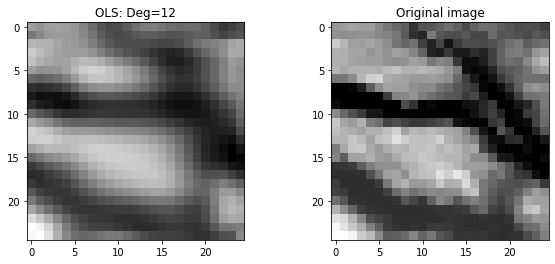

In [33]:
X = create_X(x, y, 12)

X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, z_train)
z_pred = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(model.predict(X).reshape(z.shape), cmap='gray')
ax1.set_title('OLS: Deg=12')
ax2.imshow(z, cmap='gray')
ax2.set_title('Original image')
fig.set_figwidth(10)

# __Ridge__

In [34]:
from sklearn.linear_model import Ridge

num_lambdas 20
degree = 19= 4

lambdas = np.logsp6ce6-4, 4, num_lam

ridge_train_MSE = np.zeros(num_lambdas)
ridge_test_MSE = np.zeros(num_lambdas)
ridge_r2 = np.zeros(num_lambdas)bridge_das)
cv_score = np.zeros(num_lai
itr = 0
for lmb in tqdm(lambdas):
    X = create_X(x, y, degree)

    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

    model = make_pipeline(StandardScaler(), Ridge(lmb, fit_intercept=True))
    model.fit(X_train, z_train)
    z_tilde = model.predict(X_train)
    z_pred = model.predict(X_test)

    ridge_train_MSE[itr] = mean_squared_error(z_test, z_pred)
    ridge_test_MSE[itr] = mean_squared_error(z_test, z_pred)
    ridge_r2[itr] = r2_score(z_test, z_pred)
    itr += 1core_itr += 1

100%|██████████| 20/20 [00:01<00:00, 15.62it/s]


In [35]:
cv_score_itr = 0
for lmb in tqdm(lambdas):
    X = create_X(x, y, degree)
    model = make_pipeline(StandardScaler(), Ridge(lmb, fit_intercept=True))
    ridge_cv_score[cv_score_itr] = -np.mean(cross_val_score(model, X, z.reshape(-1, 1), scoring='neg_mean_squared_error', cv=KFold(10, shuffle=True)))
    cv_score_itr += 1

100%|██████████| 20/20 [00:03<00:00,  5.16it/s]


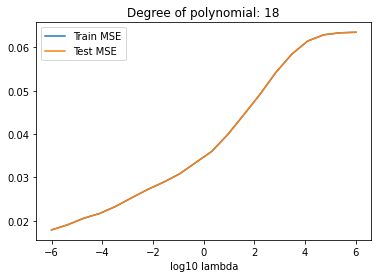

In [36]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), ridge_train_MSE, label='Train MSE')
ax.plot(np.log10(lambdas), ridge_test_MSE, label='Test MSE')
ax.legend()
ax.set_title('Degree of polynomial: {}'.format(degree - 1))
ax.set_xlabel('log10 lambda')
plt.show()how()

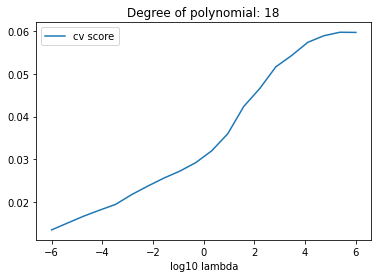

In [37]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), ridge_cv_score, label='cv score')
ax.legend()
ax.set_title('Degree of polynomial: {}'.format(degree - 1))
ax.set_xlabel('log10 lambda')
plt.show()

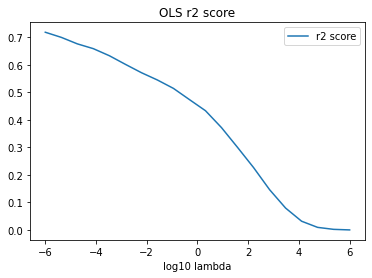

In [38]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), ridge_r2, label='r2 score')
ax.legend()
ax.set_title('OLS r2 score')
ax.set_xlabel('log10 lambda')
plt.show()

Below we perform a gridsearch to find the optimal polynomial degree and lambda value

In [39]:
max_degree = 20
degrees = np.arange(1, max_degree)

ridge_r2_grid = np.zeros((max_degree - 1, num_lambdas))

for deg in degrees:
    lmb_itr = 0
    for lmb in tqdm(lambdas):
        X = create_X(x, y, deg)

        X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

        model = make_pipeline(StandardScaler(), Ridge(lmb, fit_intercept=True))
        model.fit(X_train, z_train)
        z_pred = model.predict(X_test)

        ridge_r2_grid[deg - 1, lmb_itr] = r2_score(z_test, z_pred)
        lmb_itr += 1

100%|██████████| 20/20 [00:01<00:00, 14.53it/s]


(array([18]), array([0]))


([<matplotlib.axis.XTick at 0x7f893cdfe978>,
 [Text(0, 0, '-6'), Text(5, 0, '-3'), Text(10, 0, '0'), Text(15, 0, '3')])

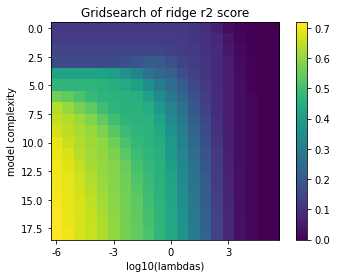

In [40]:
idx = np.where(ridge_r2_grid == np.amax(ridge_r2_grid))
print(idx)

fig, ax = plt.subplots()
cb = ax.imshow(ridge_r2_grid)
ax.set_xlabel('log10(lambdas)')
ax.set_ylabel('model complexity')
ax.set_title('Gridsearch of ridge r2 score')
plt.colorbar(cb)
plt.xticks(range(0, num_lambdas, 5), range(-6, 6, 3))

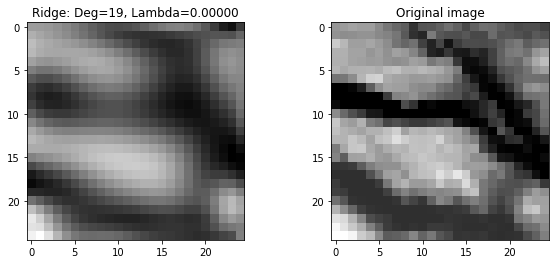

In [41]:
from sklearn.linear_model import Ridge
X = create_X(x, y, idx[0][0])

X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

model = make_pipeline(StandardScaler(), Ridge(lambdas[idx[1]], fit_intercept=True))
model.fit(X_train, z_train)
z_pred = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(model.predict(X).reshape(z.shape), cmap='gray')
ax1.set_title('Ridge: Deg={}, Lambda={:.5f}'.format(degrees[idx[0][0]], lambdas[idx[1][0]]))
ax2.imshow(z, cmap='gray')
ax2.set_title('Original image')
fig.set_figwidth(10)

# Lasso

In [42]:
from sklearn.linear_model import Lasso

num_lambdas = 20
degree = 13

lambdas = np.logspace(-6, 6, num_lambdas)

train_MSE = np.zeros(num_lambdas)
test_MSE = np.zeros(num_lambdas)
cv_score = np.zeros(num_lambdas)

mse_itr = 0
for lmb in tqdm(lambdas):
    X = create_X(x, y, degree)

    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

    model = make_pipeline(StandardScaler(), Lasso(lmb, fit_intercept=True))
    model.fit(X_train, z_train)
    z_tilde = model.predict(X_train)
    z_pred = model.predict(X_test)

    train_MSE[mse_itr] = mean_squared_error(z_tilde, z_train)
    test_MSE[mse_itr] = mean_squared_error(z_pred, z_test)
    mse_itr += 1

  0%|          | 0/20 [00:00<?, ?it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.851751150836732, tolerance: 0.002535132729780124
  positive)
/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.7224369898058445, tolerance: 0.002535132729780124
  positive)
 10%|█         | 2/20 [00:00<00:01, 11.26it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.169293008534446, tolerance: 0.002535132729780124
  positive)
/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: 

In [43]:
cv_score_itr = 0
for lmb in tqdm(lambdas):
    X = create_X(x, y, degree)
    model = make_pipeline(StandardScaler(), Lasso(lmb, fit_intercept=True))
    cv_score[cv_score_itr] = -np.mean(cross_val_score(model, X, z.reshape(-1, 1), scoring='neg_mean_squared_error', cv=KFold(10, shuffle=True)))
    cv_score_itr += 1

  0%|          | 0/20 [00:00<?, ?it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.864530583220125, tolerance: 0.003242796692342953
  positive)
/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.183497123678423, tolerance: 0.0034059005761011363
  positive)
/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.106001439243459, tolerance: 0.003325485325878213
  positive)
/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge

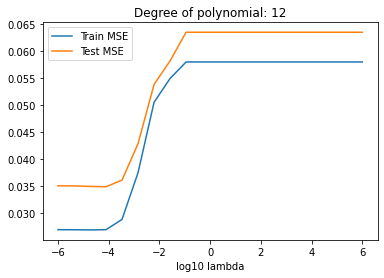

In [44]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), train_MSE, label='Train MSE')
ax.plot(np.log10(lambdas), test_MSE, label='Test MSE')
ax.legend()
ax.set_title('Degree of polynomial: {}'.format(degree - 1))
ax.set_xlabel('log10 lambda')
plt.show()

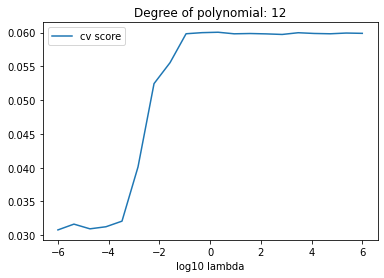

In [45]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), cv_score, label='cv score')
ax.legend()
ax.set_title('Degree of polynomial: {}'.format(degree - 1))
ax.set_xlabel('log10 lambda')
plt.show()

In [46]:
from sklearn.linear_model import Lasso

max_degree = 20
degrees = np.arange(1, max_degree)

lambdas = np.logspace(-10, 4, num_lambdas)

lasso_r2_grid = np.zeros((max_degree - 1, num_lambdas))

for deg in degrees:
    lmb_itr = 0
    for lmb in tqdm(lambdas):
        X = create_X(x, y, deg)

        X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

        model = make_pipeline(StandardScaler(), Lasso(lmb, fit_intercept=True))
        model.fit(X_train, z_train)
        z_pred = model.predict(X_test)

        lasso_r2_grid[deg - 1, lmb_itr] = r2_score(z_test, z_pred)
        lmb_itr += 1

.64it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8674964961819, tolerance: 0.002535132729780124
  positive)
 25%|██▌       | 5/20 [00:00<00:01,  8.21it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.854315114834852, tolerance: 0.002535132729780124
  positive)
 30%|███       | 6/20 [00:00<00:01,  8.01it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.782566075756897, tolerance: 0.002535132729780124
  positive)
 35%|███▌      | 7/20 [00:00<00:01,  8.00it/s]/home/hakon/.local/lib/python3.6/site

([<matplotlib.axis.XTick at 0x7f896e7ebf60>,
 [Text(0, 0, '-6'), Text(5, 0, '-3'), Text(10, 0, '0'), Text(15, 0, '3')])

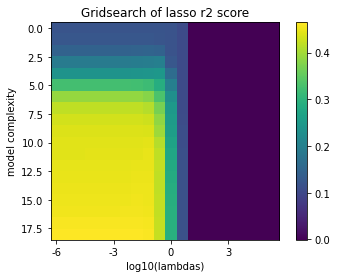

In [47]:
idx = np.where(lasso_r2_grid == np.amax(lasso_r2_grid))

fig, ax = plt.subplots()
cb = ax.imshow(lasso_r2_grid)
ax.set_xlabel('log10(lambdas)')
ax.set_ylabel('model complexity')
ax.set_title('Gridsearch of lasso r2 score')
plt.colorbar(cb)
plt.xticks(range(0, num_lambdas, 5), range(-6, 6, 3))

/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.341459771690613, tolerance: 0.002535132729780124
  positive)


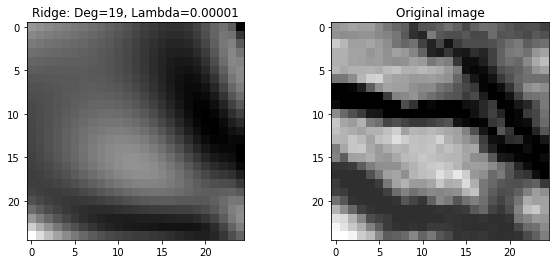

In [48]:
X = create_X(x, y, idx[0][0])

X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

model = make_pipeline(StandardScaler(), Lasso(lambdas[idx[1]], fit_intercept=True))
model.fit(X_train, z_train)
z_pred = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(model.predict(X).reshape(z.shape), cmap='gray')
ax1.set_title('Ridge: Deg={}, Lambda={:.5f}'.format(degrees[idx[0][0]], lambdas[idx[1][0]]))
ax2.imshow(z, cmap='gray')
ax2.set_title('Original image')
fig.set_figwidth(10)